In [1]:
from keras import models
from keras import layers
from keras import optimizers, losses, metrics
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image

import numpy as np
import matplotlib.pyplot as plt
import os

Using TensorFlow backend.


<br>
<br>

# 데이터 증식

훈련 데이터셋은 전체 1800개로 상당히 적은 편입니다. 이렇게 데이타가 적으면 과대적합을 발생하기 쉽습니다. 이를 해결하는 한 가지 방법은 데이터 증식(augmentation)입니다. 이미지의 경우 증식이 그리 어렵지 않습니다. 사진을 회전하거나 자르고, 명암을 변환해주는 것만으로도 데이터의 개수를 늘릴 수 있습니다.

ImgaeDataGenerator를 사용해서 데이터 증식을 해보겠습니다.
<br>
<br>
<br>

In [2]:
# 데이터셋 디렉터리 경로
dataset_dir = './dataset/caltech101'
train_dir = os.path.join(dataset_dir, 'train')
validation_dir = os.path.join(dataset_dir, 'validation')
test_dir = os.path.join(dataset_dir, 'test')

# 사진 크기
image_width = 100
image_height = 100

# 파일 목록 생성
file_list = sorted([os.path.join(train_dir+'/airplane', item) 
                    for item in os.listdir(train_dir+'/airplane')])

# 이미지 선택
file_path = file_list[0]

# 이미지 로드
img = image.load_img(file_path, target_size=(image_width, image_height))

# (width, height, 3) 크기의 넘파이 배열로 변환
x = image.img_to_array(img)

# (1, width, height, 3) 크기로 변환해야 flow()에 입력 가능
x = x.reshape((1,) + x.shape)

# 데이터 증식을 포함하여 제너레이터 생성
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

ImageDataGenerator에서 데이터 증식을 위한 파라미터는 다음과 같습니다.

1. rotation_range : 랜덤하게 회전시킬 각도
<br>
2. width_shift_range : 수평 이동 비율
<br>
3. height_shift_range : 수직 이동 비율
<br>
4. shear_range : 전단 변환 비율
<br>
5. zoom_range : 랜덤하게 확대할 비율
<br>
6. horizontal_flip : 수직을 기준으로 뒤집음
<br>
7. fill_mode : 공백 채우기 방법
<br>
<br>
<br>

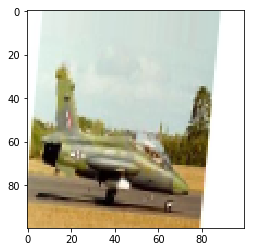

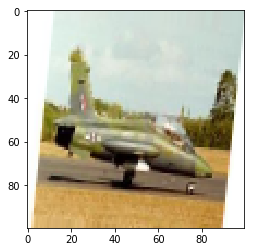

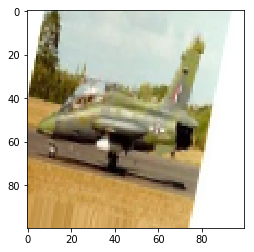

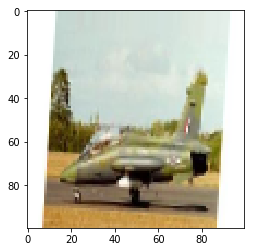

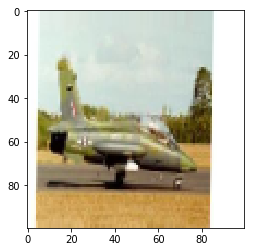

In [3]:
i = 0

for data_batch in datagen.flow(x, batch_size=1):
    plt.figure(i)
    imgplot = plt.imshow(data_batch[0])
    
    i += 1
    
    if i % 5 == 0:
        break

plt.show()


<br>
<br>

# 데이터 로드 / 전처리

In [4]:
# ImageDataGenerator 초기화
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest')

# 검증셋과 테스트셋은 증식하면 안됨
validation_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# 훈련셋 제너레이터
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(image_width, image_height),
    batch_size=16,
    class_mode='categorical')

# 검증셋 제너레이터
validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=(image_width, image_height),
    batch_size=16,
    class_mode='categorical')

# 테스트셋 제너레이터
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(image_width, image_height),
    batch_size=16,
    class_mode='categorical')


Found 1800 images belonging to 10 classes.
Found 600 images belonging to 10 classes.
Found 600 images belonging to 10 classes.


데이터 증식은 훈련셋에만 합니다. 검증셋과 테스트셋은 평가를 위해서 원본 그대로 유지할 필요가 있습니다.

이전에는 batch_size를 20으로 하였습니다. fit_generator()의 steps_per_epoch를 곱하여 전체 데이터셋의 크기가 되었기 때문입니다. 지금은 데이터 증식을 해서 랜덤하게 배치가 나옵니다. 그래서 한 에폭에 모든 데이터셋을 학습할 수 없습니다. 평소와 같이 2의 배수인 16으로 batch_size를 설정하였습니다.
<br>
<br>
<br>

In [5]:
# 훈련셋에서 배치를 생성
for data_batch, labels_batch in train_generator:
    break

In [6]:
# 데이터 배치의 크기
data_batch.shape


(16, 100, 100, 3)

In [7]:
# 라벨 배치의 크기
labels_batch.shape


(16, 10)

<br>
<br>

# 모델 생성

In [8]:
def build_model():
    
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation='relu', 
                            input_shape=(image_width, image_height, 3)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))   

    model.add(layers.Flatten())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(10, activation='softmax'))

    model.compile(optimizer='rmsprop',
                  loss='categorical_crossentropy',
                  metrics=['acc'])    
    
    return model

<br>
<br>

# 훈련 및 평가

In [9]:
# 모델 생성
model = build_model()

# 훈련 시작
history = model.fit_generator(train_generator,
                              steps_per_epoch=100,
                              epochs=50,
                              validation_data=validation_generator,
                              validation_steps=30)


Epoch 1/50
100/100 [==============================] - 146s 1s/step - loss: 1.6482 - acc: 0.4625 - val_loss: 1.0039 - val_acc: 0.7229
Epoch 2/50
100/100 [==============================] - 121s 1s/step - loss: 0.9043 - acc: 0.7075 - val_loss: 0.7146 - val_acc: 0.7712
Epoch 3/50
100/100 [==============================] - 154s 2s/step - loss: 0.6911 - acc: 0.7756 - val_loss: 0.6440 - val_acc: 0.8284
Epoch 4/50
100/100 [==============================] - 185s 2s/step - loss: 0.5987 - acc: 0.8225 - val_loss: 0.5026 - val_acc: 0.8708
Epoch 5/50
100/100 [==============================] - 185s 2s/step - loss: 0.6148 - acc: 0.8075 - val_loss: 0.3646 - val_acc: 0.8979
Epoch 6/50
100/100 [==============================] - 184s 2s/step - loss: 0.5149 - acc: 0.8513 - val_loss: 0.4344 - val_acc: 0.8919
Epoch 7/50
100/100 [==============================] - 185s 2s/step - loss: 0.5477 - acc: 0.8313 - val_loss: 0.2885 - val_acc: 0.9343
Epoch 8/50
100/100 [==============================] - 186s 2s/step - 

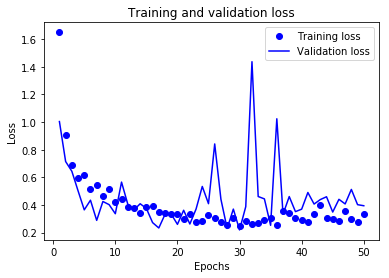

In [10]:
loss = history.history['loss']         # 훈련 손실
val_loss = history.history['val_loss'] # 검증 손실

epochs = range(1, len(loss) + 1)

plt.plot(epochs, loss, 'bo', label='Training loss')      # bo -> 파란색 점
plt.plot(epochs, val_loss, 'b', label='Validation loss') # b -> 파란색 실선
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()


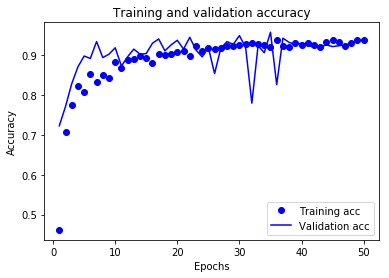

In [11]:
acc = history.history['acc']           # 훈련 정확도
val_acc = history.history['val_acc']   # 검증 정확도

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()


증식을 하지 않았을 때는 검증 정확도가 91% 였는데 이번에는 최고 94% 까지 나왔습니다. 똑같은 모델을 사용했지만 더 좋은 성능을 보이고 있습니다. 데이터가 많을수록 학습이 잘 되는 것을 알 수 있습니다.
<br>
<br>
<br>

In [12]:
# 모델 저장
model.save('./model/image_cnn_augmentation_model.h5')

<br>
<br>

# 테스트셋 확인

In [13]:
# 저장된 모델 파일 로드
model = models.load_model('./model/image_cnn_augmentation_model.h5')

In [14]:
# 테스트셋 평가
results = model.evaluate_generator(test_generator)
results


[0.4544060076245417, 0.9233333333333333]

테스트셋의 정확도가 92% 입니다. 역시 이전의 87% 보다 많이 향상되었습니다.